In [1]:
import os.path as op
import os
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import sys
from scipy import interpolate
from collections import namedtuple
import copy
import datetime

#Modules needed for SPARKLING
import algo2D_Init as init_2D
import constraints_sets as Cstr
import projectionOp as projOp
import projectedGradientDescent as pgd
import plotTrajectories

## Initializations
* nc is the number of shots in the k-space
* ns is the number of gradient samples per shot
* Oversampling factor = (gradient dwell time)/(gradient raster time)
* Kmax depends of FOV and image resolution (NS criterion)
* Gmax and Smax : maximum gradient (T/m) and slew rate (T/m/ms)
* tau and decay parametrize the variable sampling density
* mask=1 for circular isotrope kspace - 0 otherwise
* gradit = number of iterations in projected gradient descent
* init = initialization for SPARKLING (radial in-out, radial center-out, spiral in-out...)
* gamma = gyromagnetic constant (Hz/T)

In [2]:
cwd = os.getcwd()
img_size = 384   #assuming a square image
FOV = 0.23 #field of view in meters
pixelSize = FOV/img_size

#%%
samplingOptions = namedtuple("samplingOptions", "nc ns OS_factor decim tau \
                             decay mask iter init Kmax Smax Gmax gamma dTime n_revol n_epi")



samplingOptions.nc = 49
samplingOptions.ns = 2048
samplingOptions.OS_factor = 1 #gradient dwell time / gradient raster time
samplingOptions.decim = 32

#See C.Lazarus' PhD, 3.3.3 for details. Samples at the center are separated by tau*deltak, deltaK the pixel size given by Shannon
samplingOptions.decay = 2
samplingOptions.tau = 0.8

samplingOptions.init = "radialCO"
samplingOptions.mask = 1 #boolean

samplingOptions.Kmax = img_size/(2*FOV)
samplingOptions.Gmax = 40e-3 #(Tesla/meter)
samplingOptions.Smax = 200e-3 #(Tesla/meter/millisecond)

samplingOptions.gamma = 42.576e3 #gyromagnetic ratio (Hz/Tesla)
samplingOptions.dTime = 0.010     #gradient raster time in ms

samplingOptions.n_revol = 2 #number of revolutions for spirals only
samplingOptions.n_epi = 10 #number of EPI lines in k-space
samplingOptions.Shaking = 1

samplingOptions.gradit = 100 #number of iterations for the projected gradient descent

In [3]:
#KERNEL FOR ALGORITHM
kernelName = "dist_L2" #L2 norm

#Results file name
currentDT = datetime.datetime.now()

folderpath = '../Trajectories/'
fileName = samplingOptions.init + "_nc" + str(samplingOptions.nc) + "_ns" + str(samplingOptions.ns) \
+ "_decim" + str(samplingOptions.decim) + "_res" + str(img_size)+ "_tau" + str(samplingOptions.tau) \
+ "_decay" + str(samplingOptions.decay)+ "_ker" + kernelName
if not os.path.isdir(folderpath):
    os.mkdir(folderpath)
saveName = os.path.join(folderpath, fileName)

## CALCULATED VALUES

In [4]:
alpha = samplingOptions.gamma*samplingOptions.Gmax
beta = samplingOptions.gamma*samplingOptions.Smax

#Normalization of the kinetic constraints
alpha_R = alpha/(samplingOptions.Kmax)*1/(2*np.pi)
beta_R = beta/(samplingOptions.Kmax)*1/(2*np.pi)

if samplingOptions.init == "radialIO" or samplingOptions.init == "spiralIO":
     ns_shot  = 2*math.floor(samplingOptions.ns/2)+1 #odd number of samples for symmetric shots
else:
     ns_shot = samplingOptions.ns

In [5]:
#Number of shots at first decimation step
ns_shot_decim = math.ceil(ns_shot/samplingOptions.decim)

Dk0_R = 2*pixelSize/FOV*1/(2*np.pi) # kspace pixel size given by Shannon, divided by Kmax*2pi

eps = sys.float_info.epsilon

#Criterium (iii), eq (3.4) C.Lazarus' PhD thesis
alpha_R = min(Dk0_R/(samplingOptions.dTime*samplingOptions.OS_factor),alpha_R)

#UNDERSAMPLING FACTOR
UF = np.power(img_size,2)/(samplingOptions.nc*samplingOptions.ns) #R in C.Lazarus' PhD 3.3.2

#ACCELERATION FACTOR
AF = img_size/samplingOptions.nc

#%% PLOT INITIALIZATION
shot, k_TE, k_TE_decim = init_2D.init_Trajectory(samplingOptions, ns_shot_decim, img_size, eps)

k_vec = np.zeros((len(shot),2))
k_vec[:,0] = shot.real
k_vec[:,1] = shot.imag

# If constraint on echo time crossing, calcultation will be done for one center point in projectedGradientDescent
if samplingOptions.init != "Cartesian":
    samplingOptions.kTE_crossing = 1
else:
    samplingOptions.kTE_crossing = 0

Initialization for Radial Center-Out


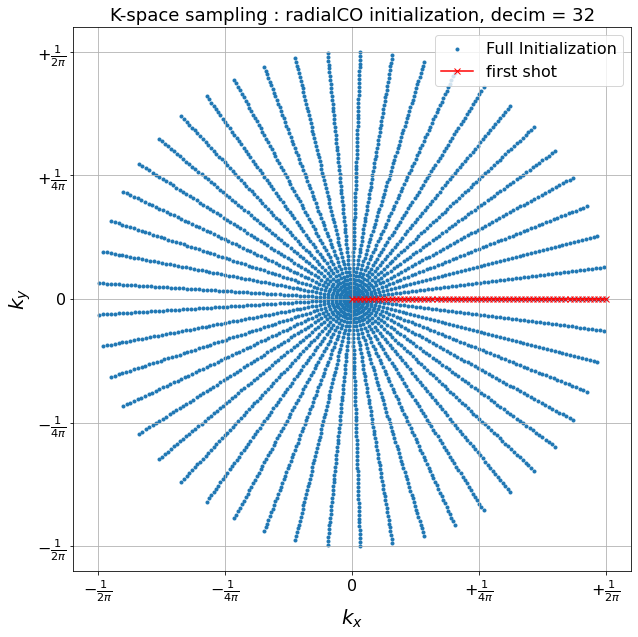

In [6]:
######################################################################################################
#Full initialization plot

kspace = plt.figure(figsize = (10,10))

if samplingOptions.init == 'EPI':
    plt.plot(k_vec[:,0],k_vec[:,1], marker = 'x', label = "Full Initialization")    
else:    
    plt.scatter(k_vec[:,0],k_vec[:,1], marker = '.', label = "Full Initialization")

plt.grid() ;


#First shot

if samplingOptions.init != 'EPI' and samplingOptions.init !="Full_Cartesian":
    
    plt.plot(k_vec[0:ns_shot_decim,0],k_vec[0:ns_shot_decim,1], color='r', marker = 'x', label = "first shot")


#Sample at echo time at the center of the k-space

if samplingOptions.init == "spiralIO" or samplingOptions.init == "radialIO":
    plt.scatter(k_vec[k_TE_decim-1,0], k_vec[k_TE_decim-1,1], marker = 'o', color='r', s = 150)

plt.title("K-space sampling : " + samplingOptions.init + " initialization, decim = " +
          str(samplingOptions.decim), fontsize = 18)

#Set labels
unit = 1/4 ; tick = np.arange(-0.5, 0.5 + unit, unit)

label_pi = [r"$-\frac{1}{2\pi}$", r"$-\frac{1}{4\pi}$", r"$0$", r"$+\frac{1}{4\pi}$",  r"$+\frac{1}{2\pi}$"]

plt.xticks(tick/np.pi,labels = label_pi, fontsize = 16)
plt.yticks(tick/np.pi,labels = label_pi, fontsize = 16)
plt.xlabel(r"$k_x$", fontsize = 20)
plt.ylabel(r"$k_y$", fontsize = 20)
plt.legend(fontsize = 16)
plt.show()


## GENERATE Plateau distribution

VDS maxDens = 1.5570192920918364e-05
jb = 13
rmin = 0.010776115938513749
max p_peak is 8.615470710691092e-06
total density =  1.000000


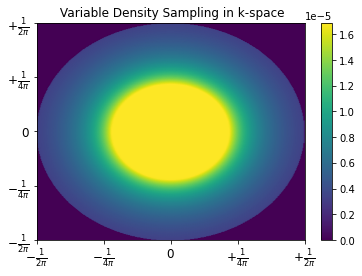

In [7]:
x = np.linspace(-img_size/2+0.5, img_size/2-0.5,img_size)

#Algorithm described in C.Lazarus' PhD, section 3.3.3
X,Y = np.meshgrid(x,x) 
norm = np.sqrt(np.power(X,2)+np.power(Y,2))
p_decay = np.power(norm, -samplingOptions.decay)
p_decay = p_decay/np.sum(p_decay)

maxDens = 1/(ns_shot*samplingOptions.nc*np.power(samplingOptions.tau,2)) #eq (3.12) in C.Lazarus' PhD
print("VDS maxDens = " + str(maxDens))

p_peak = init_2D.Generate_Peak(samplingOptions.nc, samplingOptions.nc*ns_shot,img_size, 
                       alpha_R, samplingOptions.dTime, Dk0_R, samplingOptions.tau)

x = np.linspace(-1/(2*np.pi), 1/(2*np.pi),img_size)
X, Y = np.meshgrid(x,x)

density = init_2D.generate_density(p_peak, p_decay, maxDens)
density = density/np.sum(density)

#In the case an isotropic mask is applied (ie k-samples in a disc)
if samplingOptions.mask == 1:
    density[np.where(norm >= img_size/2-1/2)] = 0
    density = density/(np.sum(density)) #normalization

densPlot = plt.figure()

plt.pcolormesh(X, Y, density, shading="gouraud")
plt.colorbar()
plt.xticks(tick/np.pi,labels = label_pi, fontsize = 12)
plt.yticks(tick/np.pi,labels = label_pi, fontsize = 12)
plt.title(" Variable Density Sampling in k-space")
print("total density =  %1.6f" %np.sum(density))
plt.show()


## SET KINETIC CONSTRAINTS

In [8]:
func = Cstr.bound_normL2()

C_speed = Cstr.kinetic_Constraint(func, lambda s : Cstr.Prime(s,1), 
                         lambda s : Cstr.PrimeT(s,1), alpha_R*samplingOptions.dTime)

def Second(s,Dt):
    spp = -Cstr.PrimeT(Cstr.Prime(s,Dt),Dt)
    return spp

C_accel = Cstr.kinetic_Constraint(func, lambda s : Second(s,1), 
                         lambda s : Second(s,1), beta_R*np.power(samplingOptions.dTime,2))

print("C_speed.bound is %1.6f" %C_speed.bound)
print("C_accel.bound is %1.6f" %C_accel.bound)

C_kin = np.array([C_speed, C_accel])

C_speed.bound is 0.000829
C_accel.bound is 0.000162


## MAIN ALGORITHM OPTIONS


In [9]:
algoParams = namedtuple("algoParams", 
                        "nit L discr_step nCheb treeDepth target_acc disp_results show_prog mode kernelID")

algoParams.nit = 50 #number of iteration for projection on constraints space
algoParams.L = 16 #Lipschitz constant of the gradient
algoParams.discr_step = 1

#Parameters for Black-Box FMM ; tree depth and target accuracy are not controlled by user in this 2D implementation
algoParams.nCheb = 5 #number of Chebyshev nodes for interpolation
algoParams.mode = 1 #1 for multiple, 0 for single

if kernelName == "dist_L2":
    algoParams.kernelID = 1
elif kernelName == "log_L2":
    algoParams.kernelID = 2
elif kernelName == "gaussian":
    algoParams.kernelID = 3

saveName = saveName + "_nCheb" + str(algoParams.nCheb) + "_gradit" + str(samplingOptions.gradit) \
 +  "_D" + str(currentDT.day) + "M"+ str(currentDT.month)+ "Y" + str(currentDT.year)
 

#set to false, not available in current version
algoParams.disp_results = False
algoParams.show_prog = False

nc = samplingOptions.nc

print("ns_shot_decim = %d" %ns_shot_decim)
#print("k_TE_decim = %d" %k_TE_decim)

decim = samplingOptions.decim
stepDef = 1/(2*np.pi)*1/16 #in sparkling2D_standalone, Create_SPARKLING.m

#Structure containing shot as well as the dual variables (projection algorithm)
algoProj = namedtuple("algoProj", "s")

kshot = np.zeros((len(shot),2))
kshot[:,0] = shot.real
kshot[:,1] = shot.imag

ns_shot_decim = 64


## PROJECTED GRADIENT DESCENT SPARKLING

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12

decimation factor is 32
Started subgradient descent


  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  4% (4 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  5% (5 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  6% (6 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  7% (7 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  8% (8 of 100) |#                       | Ela

 36% (36 of 100) |########               | Elapsed Time: 0:00:04 ETA:   0:00:08WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 37% (37 of 100) |########               | Elapsed Time: 0:00:04 ETA:   0:00:08WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 38% (38 of 100) |########               | Elapsed Time: 0:00:05 ETA:   0:00:08WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 39% (39 of 100) |########               | Elapsed Time: 0:00:05 ETA:   0:00:08WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 40% (40 of 100) |#########              | Elapsed Time: 0:00:05 ETA:   0:00:08WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 41% (41 of 100) |#########              | Elapsed Time: 0:00:05 ETA:   0:00:07WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 42% (42 of 100) |#########              | Ela

 70% (70 of 100) |################       | Elapsed Time: 0:00:09 ETA:   0:00:04WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 71% (71 of 100) |################       | Elapsed Time: 0:00:09 ETA:   0:00:03WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 72% (72 of 100) |################       | Elapsed Time: 0:00:09 ETA:   0:00:03WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 73% (73 of 100) |################       | Elapsed Time: 0:00:09 ETA:   0:00:03WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 74% (74 of 100) |#################      | Elapsed Time: 0:00:09 ETA:   0:00:03WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 75% (75 of 100) |#################      | Elapsed Time: 0:00:10 ETA:   0:00:03WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 76% (76 of 100) |#################      | Ela

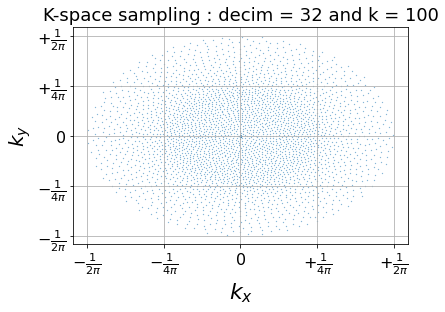

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

decimation factor is 16
Started subgradient descent


  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  4% (4 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  5% (5 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:17WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:17WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  7% (7 of 100) |#                       | Ela

 35% (35 of 100) |########               | Elapsed Time: 0:00:06 ETA:   0:00:13WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 36% (36 of 100) |########               | Elapsed Time: 0:00:07 ETA:   0:00:13WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 37% (37 of 100) |########               | Elapsed Time: 0:00:07 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 38% (38 of 100) |########               | Elapsed Time: 0:00:07 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 39% (39 of 100) |########               | Elapsed Time: 0:00:07 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 40% (40 of 100) |#########              | Elapsed Time: 0:00:07 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 41% (41 of 100) |#########              | Ela

 69% (69 of 100) |###############        | Elapsed Time: 0:00:13 ETA:   0:00:06WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 70% (70 of 100) |################       | Elapsed Time: 0:00:14 ETA:   0:00:05WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 71% (71 of 100) |################       | Elapsed Time: 0:00:14 ETA:   0:00:05WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 72% (72 of 100) |################       | Elapsed Time: 0:00:14 ETA:   0:00:05WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 73% (73 of 100) |################       | Elapsed Time: 0:00:14 ETA:   0:00:05WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 74% (74 of 100) |#################      | Elapsed Time: 0:00:14 ETA:   0:00:05WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 75% (75 of 100) |#################      | Ela

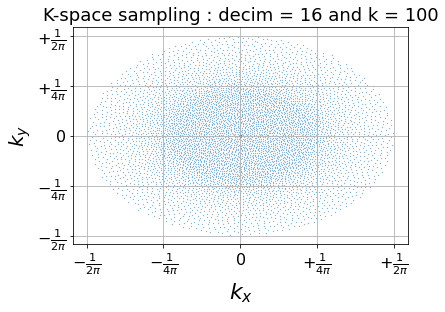

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

decimation factor is 8
Started subgradient descent


  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:25WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:25WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:24WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:24WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:24WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  7% (7 of 100) |#                       | Ela

 35% (35 of 100) |########               | Elapsed Time: 0:00:10 ETA:   0:00:18WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 36% (36 of 100) |########               | Elapsed Time: 0:00:10 ETA:   0:00:17WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 37% (37 of 100) |########               | Elapsed Time: 0:00:10 ETA:   0:00:17WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 38% (38 of 100) |########               | Elapsed Time: 0:00:11 ETA:   0:00:17WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 39% (39 of 100) |########               | Elapsed Time: 0:00:11 ETA:   0:00:16WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 40% (40 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:16WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 41% (41 of 100) |#########              | Ela

 69% (69 of 100) |###############        | Elapsed Time: 0:00:20 ETA:   0:00:08WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 70% (70 of 100) |################       | Elapsed Time: 0:00:20 ETA:   0:00:08WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 71% (71 of 100) |################       | Elapsed Time: 0:00:20 ETA:   0:00:08WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 72% (72 of 100) |################       | Elapsed Time: 0:00:20 ETA:   0:00:07WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 73% (73 of 100) |################       | Elapsed Time: 0:00:21 ETA:   0:00:07WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 74% (74 of 100) |#################      | Elapsed Time: 0:00:21 ETA:   0:00:07WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 75% (75 of 100) |#################      | Ela

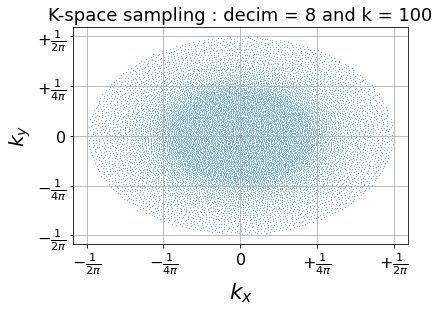

decimation factor is 4


  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Started subgradient descent


  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:43WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:46WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:45WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:45WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:45WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  6% (6 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:44WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  7% (7 of 100) |#                       | Ela

 35% (35 of 100) |########               | Elapsed Time: 0:00:18 ETA:   0:00:34WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 36% (36 of 100) |########               | Elapsed Time: 0:00:19 ETA:   0:00:33WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 37% (37 of 100) |########               | Elapsed Time: 0:00:19 ETA:   0:00:33WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 38% (38 of 100) |########               | Elapsed Time: 0:00:20 ETA:   0:00:31WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 39% (39 of 100) |########               | Elapsed Time: 0:00:20 ETA:   0:00:31WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 40% (40 of 100) |#########              | Elapsed Time: 0:00:21 ETA:   0:00:30WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 41% (41 of 100) |#########              | Ela

 69% (69 of 100) |###############        | Elapsed Time: 0:00:34 ETA:   0:00:13WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 70% (70 of 100) |################       | Elapsed Time: 0:00:35 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 71% (71 of 100) |################       | Elapsed Time: 0:00:35 ETA:   0:00:12WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 72% (72 of 100) |################       | Elapsed Time: 0:00:35 ETA:   0:00:11WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 73% (73 of 100) |################       | Elapsed Time: 0:00:36 ETA:   0:00:11WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 74% (74 of 100) |#################      | Elapsed Time: 0:00:36 ETA:   0:00:10WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 75% (75 of 100) |#################      | Ela

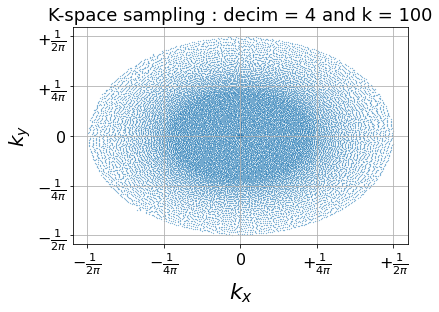

decimation factor is 2


  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Started subgradient descent


  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:21WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:19WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:19WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:18WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:19WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:18WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  7% (7 of 100) |#                       | Ela

 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:51WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:50WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:49WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:48WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:47WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:47WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 41% (41 of 100) |#########              | Ela

 69% (69 of 100) |###############        | Elapsed Time: 0:00:54 ETA:   0:00:24WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 70% (70 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:23WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 71% (71 of 100) |################       | Elapsed Time: 0:00:56 ETA:   0:00:22WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 72% (72 of 100) |################       | Elapsed Time: 0:00:57 ETA:   0:00:21WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 73% (73 of 100) |################       | Elapsed Time: 0:00:58 ETA:   0:00:21WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 74% (74 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:20WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 75% (75 of 100) |#################      | Ela

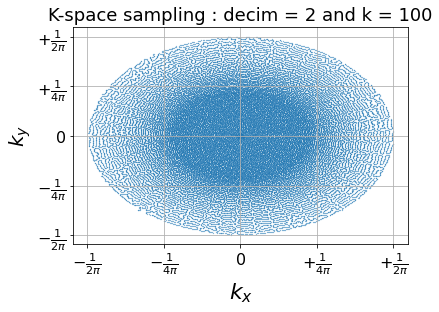

decimation factor is 1


  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Started subgradient descent


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:25WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:23WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  3% (3 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:02:22WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  4% (4 of 100) |                        | Elapsed Time: 0:00:05 ETA:   0:02:22WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  5% (5 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:02:20WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  6% (6 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:02:18WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
  7% (7 of 100) |#                       | Ela

 35% (35 of 100) |########               | Elapsed Time: 0:00:52 ETA:   0:01:37WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 36% (36 of 100) |########               | Elapsed Time: 0:00:53 ETA:   0:01:35WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 37% (37 of 100) |########               | Elapsed Time: 0:00:55 ETA:   0:01:34WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 38% (38 of 100) |########               | Elapsed Time: 0:00:56 ETA:   0:01:31WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 39% (39 of 100) |########               | Elapsed Time: 0:00:58 ETA:   0:01:30WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 40% (40 of 100) |#########              | Elapsed Time: 0:00:59 ETA:   0:01:33WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 41% (41 of 100) |#########              | Ela

 69% (69 of 100) |###############        | Elapsed Time: 0:01:43 ETA:   0:00:46WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 70% (70 of 100) |################       | Elapsed Time: 0:01:45 ETA:   0:00:44WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 71% (71 of 100) |################       | Elapsed Time: 0:01:46 ETA:   0:00:43WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 72% (72 of 100) |################       | Elapsed Time: 0:01:48 ETA:   0:00:41WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 73% (73 of 100) |################       | Elapsed Time: 0:01:49 ETA:   0:00:39WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 74% (74 of 100) |#################      | Elapsed Time: 0:01:51 ETA:   0:00:38WARNING: <class 'projectionOp.GradientL2'> does not inherit an operator parent.
 75% (75 of 100) |#################      | Ela

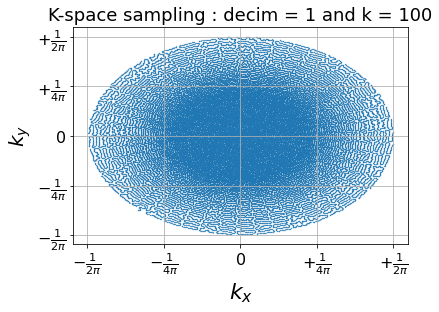

In [10]:
algoProj.s = np.copy(kshot)

#Attraction field depends only on the kernel and the VDS
Att_field, x_att, y_att = pgd.Precompute_Attraction_Field(density, kernelName)

while decim >= 1 :
    
    tol = 1e-6 * decim
    
    print("decimation factor is %d" %decim)
    
    #Kinetic bounds change with decimation
    C_kin_decim = copy.deepcopy(C_kin) #Copy is mandatory in this case, otherwise C_kin will be modified as well!
    C_kin_decim[0].bound  = C_kin_decim[0].bound * decim
    C_kin_decim[1].bound = C_kin_decim[1].bound*np.power(decim,2)
    
    #Linear Constraints
    C_lin = Cstr.linear_Constraint() #"Projection au bout de la nuit"

    if samplingOptions.kTE_crossing ==1:
        Cstr.set_lin_constraints_kTE(C_lin, ns_shot_decim, 2, "TE_point", k_TE_decim)
    else:
        Cstr.set_lin_constraints_kTE(C_lin, ns_shot_decim, 2)

    
    #First Projection of Initial trajectories
    if decim == samplingOptions.decim and decim > 1:
        algoProj = projOp.project_fast_fista(C_kin_decim, C_lin, algoParams, algoProj, nc)
        #algoProj = proj_Cstr.Projector_On_Multiple_Curves_Center(C_kin_decim, C_lin, algoParams, algoProj, nc)
        kshot = np.copy(algoProj.s)
        

    #Projected Gradient Descent
    kshot = pgd.gradDescent(density, decim, kshot, C_kin_decim, C_lin, x_att, y_att, Att_field, kernelName, samplingOptions, tol,
                            int(k_TE_decim), stepDef, algoParams)
    
    # Plot distribution at the end of each decimation step
    plotTrajectories.dispSampling(kshot, decim, samplingOptions.gradit)
    
    decim = int(decim/2)
    
    ns_shot_decim_prev = ns_shot_decim
    
    if k_TE != 1: #ie if echo time is not at first sample
        ns_shot_decim = 2*(ns_shot_decim - 1) + 1
        k_TE_decim = 2*(k_TE_decim - 1) + 1
    else:
        ns_shot_decim = 2*ns_shot_decim
    
    #At next decimation, initialization with more samples is done by interpolation with current distribution on each curve
    if decim >= 1:
        
        shotx = np.array([])
        shoty = np.array([])
        
        for k in np.arange(0, nc):
            
            segment = kshot[ns_shot_decim_prev*k:(k+1)*ns_shot_decim_prev, :]  
            fx = interpolate.interp1d(np.linspace(-1/(2*np.pi),1/(2*np.pi), ns_shot_decim_prev), 
                                      segment[:,0], kind = 'linear')
            fy = interpolate.interp1d(np.linspace(-1/(2*np.pi),1/(2*np.pi), ns_shot_decim_prev), 
                                      segment[:,1], kind = 'linear')
            sx = fx(np.linspace(-1/(2*np.pi), 1/(2*np.pi), ns_shot_decim))
            sy = fy(np.linspace(-1/(2*np.pi), 1/(2*np.pi), ns_shot_decim))
            shotx = np.append(shotx, sx)
            shoty = np.append(shoty, sy)

        kshot = np.zeros((shotx.shape[0],2))
        kshot[:,0] = shotx
        kshot[:,1] = shoty
        
    algoProj.s = kshot


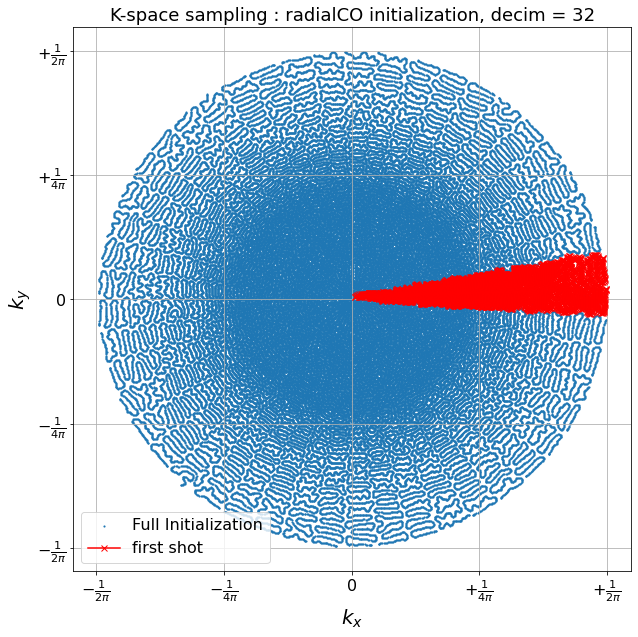

In [13]:
######################################################################################################
#Plot Result

kspace = plt.figure(figsize = (10,10))
k_vec = kshot
if samplingOptions.init == 'EPI':
    plt.plot(k_vec[:,0],k_vec[:,1], marker = 'x', label = "Full Initialization", s=10)    
else:    
    plt.scatter(k_vec[:,0],k_vec[:,1], marker = '.', label = "Full Initialization", s=5)

plt.grid() ;


#First shot

if samplingOptions.init != 'EPI' and samplingOptions.init !="Full_Cartesian":
    
    plt.plot(k_vec[0:ns_shot_decim,0],k_vec[0:ns_shot_decim,1], color='r', marker = 'x', label = "first shot")


#Sample at echo time at the center of the k-space

if samplingOptions.init == "spiralIO" or samplingOptions.init == "radialIO":
    plt.scatter(k_vec[k_TE_decim-1,0], k_vec[k_TE_decim-1,1], marker = 'o', color='r', s = 150)

plt.title("K-space sampling : " + samplingOptions.init + " initialization, decim = " +
          str(samplingOptions.decim), fontsize = 18)

#Set labels
unit = 1/4 ; tick = np.arange(-0.5, 0.5 + unit, unit)

label_pi = [r"$-\frac{1}{2\pi}$", r"$-\frac{1}{4\pi}$", r"$0$", r"$+\frac{1}{4\pi}$",  r"$+\frac{1}{2\pi}$"]

plt.xticks(tick/np.pi,labels = label_pi, fontsize = 16)
plt.yticks(tick/np.pi,labels = label_pi, fontsize = 16)
plt.xlabel(r"$k_x$", fontsize = 20)
plt.ylabel(r"$k_y$", fontsize = 20)
plt.legend(fontsize = 16)
plt.show()
